In [1]:
from tensorflow.keras.datasets import imdb
import pandas as pd
import numpy as np
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from keras.layers.embeddings import Embedding
from tensorflow.keras.models import Model
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [31]:
from tensorflow.keras.datasets import imdb
import pandas as pd
import numpy as np
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from keras.layers.embeddings import Embedding
from tensorflow.keras.models import Model
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('memotion_dataset_7k/labels.csv')
data.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [3]:
meme_text = pd.DataFrame()
meme_text['text'] = data.text_corrected
meme_text['sentiment'] = data.overall_sentiment
meme_text.head()

,text,sentiment
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,positive
1,The best of #10 YearChallenge! Completed in le...,positive
2,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,10 Year Challenge - Sweet Dee Edition,positive
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [4]:
cleaned = meme_text.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

text         False
sentiment    False
dtype: bool

In [5]:
target = cleaned['sentiment']
target = pd.get_dummies(target)
labels = []
for _, i in target.iterrows():
    labels.append(np.argmax(i))
labels[0:5]

[2, 2, 2, 2, 1]

In [6]:
cleaned.shape

(6987, 2)

In [7]:
import nlpaug
import nlpaug.augmenter.word as naw
def Augmentation(text, labels):
    aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)
    augmented_sentences = []
    augmented_sentences_labels = []
    for i in range(0, len(text)):
        if np.argmax(labels.iloc[i]) == 0:
            t = 0
            temps = aug.augment(text.iloc[i],n=6)
        elif np.argmax(labels.iloc[i]) == 1:
            t = 1
            temps = aug.augment(text.iloc[i],n=2)
        else:
            augmented_sentences.append(text.iloc[i])
            augmented_sentences_labels.append(2)
            continue
        for sent in temps:
            augmented_sentences.append(sent)
            augmented_sentences_labels.append(t)
        
    return augmented_sentences,augmented_sentences_labels

In [8]:
text, sent = Augmentation(cleaned.text, target)
cleaned = pd.DataFrame()
cleaned['text'] = text
cleaned['sentiment'] = sent

In [9]:
from tensorflow.keras.utils import to_categorical
sent = to_categorical(sent)
pd.DataFrame(text).shape, pd.DataFrame(sent).shape

((12342, 1), (12342, 3))

In [10]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [11]:
def remove_stopwords(data):
    data['text'] = data['text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
    return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
 
data_without_stopwords = []
data_without_stopwords = remove_stopwords(cleaned)
data_without_stopwords['text']= data_without_stopwords['text'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['text'] = data_without_stopwords['text'].str.replace('[{}]'.format(string.punctuation), ' ')

C:\Users\hp\AppData\Local\Temp/ipykernel_1740/1822268650.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data_without_stopwords['text'] = data_without_stopwords['text'].str.replace('[{}]'.format(string.punctuation), ' ')


In [12]:
meme_text = data_without_stopwords.text
sentiment = data_without_stopwords['sentiment']

In [13]:
y = sent
#y = pd.get_dummies(target)
pd.DataFrame(y).head()

,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [14]:
X_train, X_test,Y_train, Y_test = train_test_split(meme_text, y, test_size=0.3, random_state = 45)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.4)
X_train.shape, X_test.shape, X_val.shape

((8639,), (2221,), (1482,))

In [15]:
pd.DataFrame(Y_train).value_counts()

0    1    2  
0.0  1.0  0.0    3057
     0.0  1.0    2949
1.0  0.0  0.0    2633
dtype: int64

In [16]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [17]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

In [18]:
word_to_vec_map = read_glove_vector('glove.6B.50d.txt')

maxLen = 150

In [19]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index-1, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [28]:
def Sent_Analysis(input_shape):

    X_indices = Input(input_shape)

    embeddings = embedding_layer(X_indices)

    X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)

    X = Dropout(0.6)(X)

    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    X = Dropout(0.6)(X)
    
    X = LSTM(256, return_sequences=True)(X)
    X = Dropout(0.6)(X)
    
    X = Conv1D(256,3,activation='relu')(X)
    X = Dropout(0.6)(X)
    
    X = Conv1D(256,3,activation='relu')(X)
    X = Dropout(0.6)(X)

    X = Bidirectional(LSTM(128))(X)

    X = Dense(3, activation='softmax')(X)

    model = Model(inputs=X_indices, outputs=X)

    return model

In [44]:
def conv1d_model(input_shape):

    X_indices = Input(input_shape)

    embeddings = embedding_layer(X_indices)

    X = Conv1D(128,3,activation='relu')(embeddings)
    #X = Dropout(0.8)(X)
    
    X = Conv1D(128,3,activation='relu')(embeddings)
    X = Dropout(0.6)(X)

    X = MaxPooling1D(2)(X)

#     X = Conv1D(256,3,activation='relu')(X)
#     X = Dropout(0.6)(X)
#     X = MaxPooling1D(2)(X)

    X = Conv1D(128,3,activation='relu')(X)
    X = Dropout(0.6)(X)
    #X = MaxPooling1D(2)(X)

    X = GlobalMaxPooling1D()(X)

    X = Dense(128, activation='relu')(X)
    X = Dense(3, activation='softmax')(X)

    model = Model(inputs=X_indices, outputs=X)

    return model

In [32]:
model = Sent_Analysis((maxLen,))
model.summary()

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.embedding_lookup_3), but
are not present in its tracked objects:
  <tf.Variable 'embedding/embeddings:0' shape=(13161, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
tf.cast_3 (TFOpLambda)       (None, 150)               0         
_________________________________________________________________
tf.compat.v1.nn.embedding_lo (None, 150, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 256)  

In [45]:
model_1d = conv1d_model((maxLen,))
model_1d.summary()

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.embedding_lookup_7), but
are not present in its tracked objects:
  <tf.Variable 'embedding/embeddings:0' shape=(13161, 50) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
tf.cast_7 (TFOpLambda)       (None, 150)               0         
_________________________________________________________________
tf.compat.v1.nn.embedding_lo (None, 150, 50)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 148, 128)  

In [24]:
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_val_indices = tokenizer.texts_to_sequences(X_val)

In [25]:
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_val_indices = pad_sequences(X_val_indices, maxlen=maxLen, padding='post')
X_train_indices.shape, X_val_indices.shape

((8639, 150), (1482, 150))

In [46]:
#adam = keras.optimizers.Adam(learning_rate = 0.0001)
model_1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
model_1d.fit(X_train_indices, Y_train, validation_data = (X_val_indices, Y_val), batch_size=64, epochs=30)

Epoch 1/30
135/135 [==============================] - 2s 10ms/step - loss: 1.1826 - accuracy: 0.3594 - val_loss: 1.0881 - val_accuracy: 0.3900
Epoch 2/30
135/135 [==============================] - 1s 9ms/step - loss: 1.0948 - accuracy: 0.3830 - val_loss: 1.0881 - val_accuracy: 0.4001
Epoch 3/30
135/135 [==============================] - 1s 9ms/step - loss: 1.0824 - accuracy: 0.3862 - val_loss: 1.0798 - val_accuracy: 0.4076
Epoch 4/30
135/135 [==============================] - 1s 9ms/step - loss: 1.0725 - accuracy: 0.4076 - val_loss: 1.0747 - val_accuracy: 0.4379
Epoch 5/30
135/135 [==============================] - 1s 9ms/step - loss: 1.0650 - accuracy: 0.4190 - val_loss: 1.0724 - val_accuracy: 0.4305
Epoch 6/30
135/135 [==============================] - 1s 9ms/step - loss: 1.0579 - accuracy: 0.4209 - val_loss: 1.0625 - val_accuracy: 0.4548
Epoch 7/30
135/135 [==============================] - 1s 8ms/step - loss: 1.0493 - accuracy: 0.4252 - val_loss: 1.0587 - val_accuracy: 0.4663
Epoch

In [48]:
#adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
model.fit(X_train_indices, Y_train,validation_data = (X_val_indices, Y_val), batch_size=64, epochs=15)

Epoch 1/15
135/135 [==============================] - 30s 176ms/step - loss: 1.1011 - accuracy: 0.3526 - val_loss: 1.0846 - val_accuracy: 0.4035
Epoch 2/15
135/135 [==============================] - 22s 166ms/step - loss: 1.0821 - accuracy: 0.3917 - val_loss: 1.0654 - val_accuracy: 0.3988
Epoch 3/15
135/135 [==============================] - 22s 164ms/step - loss: 1.0693 - accuracy: 0.4036 - val_loss: 1.0618 - val_accuracy: 0.4001
Epoch 4/15
135/135 [==============================] - 22s 165ms/step - loss: 1.0544 - accuracy: 0.4208 - val_loss: 1.0477 - val_accuracy: 0.4318
Epoch 5/15
135/135 [==============================] - 22s 167ms/step - loss: 1.0384 - accuracy: 0.4311 - val_loss: 1.0167 - val_accuracy: 0.4345
Epoch 6/15
135/135 [==============================] - 22s 167ms/step - loss: 1.0100 - accuracy: 0.4632 - val_loss: 1.0116 - val_accuracy: 0.4548
Epoch 7/15
135/135 [==============================] - 22s 166ms/step - loss: 0.9695 - accuracy: 0.4850 - val_loss: 1.0209 - val_ac

In [50]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

In [52]:
y_pred1 = model.predict(X_test_indices)
y_pred2 = model_1d.predict(X_test_indices)

In [53]:
yt = np.argmax(Y_test, axis = 1)
yp1 = np.argmax(y_pred1, axis = 1)
yp2 = np.argmax(y_pred2, axis = 1)

In [54]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(yt, yp1), accuracy_score(yt, yp2)

(0.5727149932462855, 0.5983791085096803)

In [55]:
print(classification_report(yt,yp1), classification_report(yt,yp2))

              precision    recall  f1-score   support

           0       0.67      0.84      0.74       687
           1       0.52      0.47      0.49       811
           2       0.51      0.43      0.47       723

    accuracy                           0.57      2221
   macro avg       0.56      0.58      0.57      2221
weighted avg       0.56      0.57      0.56      2221
               precision    recall  f1-score   support

           0       0.79      0.71      0.75       687
           1       0.55      0.47      0.51       811
           2       0.50      0.64      0.56       723

    accuracy                           0.60      2221
   macro avg       0.62      0.61      0.61      2221
weighted avg       0.61      0.60      0.60      2221



Text(33.0, 0.5, 'Truth')

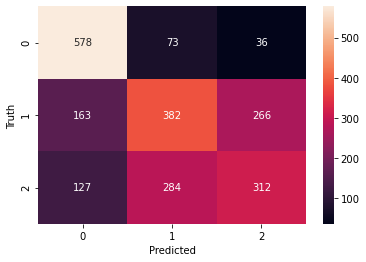

In [56]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
cm = confusion_matrix(yt, yp1)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(33.0, 0.5, 'Truth')

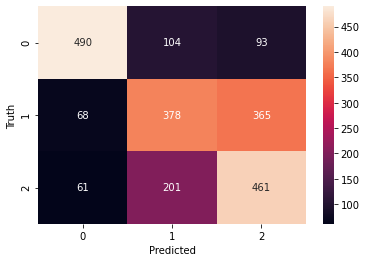

In [57]:
cm = confusion_matrix(yt, yp2)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')